## Training on Socat vs. real pco2

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-01-30 13:52:32.738384: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def preprocess_images_nfp(dir_name,num="001",socat=False):
    
    chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num)
    
    if socat:

        chl_images = preprocess_image_reduced(chl.Chl_socat.data)
        mld_images = preprocess_image_reduced(mld.MLD_socat.data)
        sss_images = preprocess_image_reduced(sss.SSS_socat.data)
        sst_images = preprocess_image_reduced(sst.SST_socat.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images_socat = preprocess_image_reduced(pco2.pCO2_socat.data)
    else:
        chl_images = preprocess_image_reduced(chl.Chl.data)
        mld_images = preprocess_image_reduced(mld.MLD.data)
        sss_images = preprocess_image_reduced(sss.SSS.data)
        sst_images = preprocess_image_reduced(sst.SST.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)

    pco2_images = preprocess_image_reduced(pco2.pCO2.data)
    
    X = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images,pco2_images_socat))
    X = X.reshape((421,180,360,6),order='F')

    return X, pco2_images



In [3]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"


data,pco2 = preprocess_images_nfp(dir_name,socat=True)
test_data,test_pco2 = preprocess_images_nfp(val_dir_name,"035",True)

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [ ]:

figure, axis = plt.subplots(2, 3,figsize=(15, 9))


img=axis[0][0].imshow(np.flipud(data[419][:,:,0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("chl")


img1=axis[0][1].imshow(np.flipud(data[419][:,:,1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("mld")

img2=axis[0][2].imshow(np.flipud(data[419][:,:,2]),cmap="coolwarm", interpolation="nearest")
axis[0][2].set_title("sss")


img=axis[1][0].imshow(np.flipud(data[419][:,:,3]),cmap="coolwarm", interpolation="nearest")
axis[1][0].set_title("sst")



img2=axis[1][1].imshow(np.flipud(data[419][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("pco2")




plt.colorbar(img,ax=axis)

plt.show()



NameError: name 'plt' is not defined

In [5]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

In [6]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

# gives you gradient exploding problem

y=np.expand_dims(pco2[X_index][1:],axis=4)
X=data[X_index][:-1]


val_y=np.expand_dims(test_pco2[X_index][1:],axis=4)
val_X=test_data[X_index][:-1]

In [7]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=y[0].shape

INPUT_SHAPE

(3, 180, 360, 6)

In [14]:
tf.keras.backend.clear_session()

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial

DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)



model = keras.models.Sequential([
    DefaultConvLSTM2D(input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(5,5)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(1,1)),
    keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),activation="elu", padding="same")
    
])


model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(),
)

In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8

In [17]:
model_path="../../models/socat_CNN_LSTM_new.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 8

# Fit the model to the training data.
model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_X, val_y),
    callbacks=callbacks,
)

Epoch 1/20
53/53 [==============================] - 77s 1s/step - loss: 76.5533 - val_loss: 24.2465
Epoch 2/20
53/53 [==============================] - 68s 1s/step - loss: 18.9297 - val_loss: 27.8053
Epoch 3/20
53/53 [==============================] - 68s 1s/step - loss: 14.5816 - val_loss: 28.1026
Epoch 4/20
53/53 [==============================] - 68s 1s/step - loss: 14.3103 - val_loss: 28.3738
Epoch 5/20
53/53 [==============================] - 68s 1s/step - loss: 14.3092 - val_loss: 22.7070
Epoch 6/20
53/53 [==============================] - 68s 1s/step - loss: 14.5167 - val_loss: 22.9631
Epoch 7/20
53/53 [==============================] - 68s 1s/step - loss: 14.0784 - val_loss: 18.3113
Epoch 8/20
53/53 [==============================] - 68s 1s/step - loss: 14.0766 - val_loss: 14.4404
Epoch 9/20
53/53 [==============================] - 68s 1s/step - loss: 13.9076 - val_loss: 15.3959
Epoch 10/20
53/53 [==============================] - 69s 1s/step - loss: 14.1198 - val_loss: 13.4946

KeyboardInterrupt: 

In [18]:
best_model = tf.keras.models.load_model('../../models/socat_CNN_LSTM_new.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_frames=best_model.predict(X,verbose=1)

14/14 [==============================] - 15s 1s/step


In [19]:
predicted_frames[y==0]=0.0

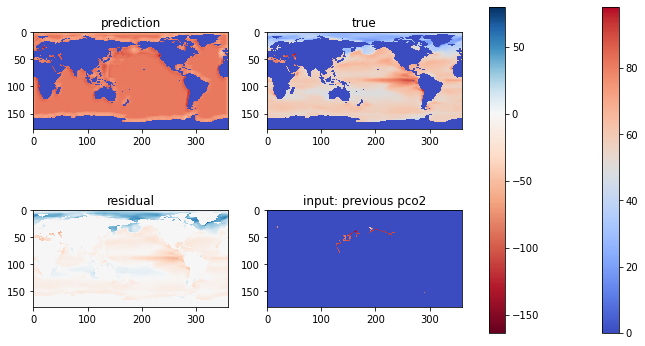

In [20]:
import matplotlib.colors as mcolors


figure, axis = plt.subplots(2, 2,figsize=(12, 6))

d = predicted_frames - y
norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


img=axis[0][0].imshow(np.flipud(predicted_frames[232][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y[232][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[232][1]-y[232][1]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(X[232][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("input: previous pco2")

plt.show()